In [18]:
#
# https://github.com/Pyomo/pyomo/blob/master/pyomo/contrib/parmest/examples/rooney_biegler/rooney_biegler_parmest.py
#

In [15]:
import pandas as pd
import pyomo.environ as pyo
import pyomo.contrib.parmest.parmest as parmest
import numpy as np
from itertools import product

In [2]:
def rooney_biegler_model(data):
    
    model = pyo.ConcreteModel()

    model.asymptote = pyo.Var(initialize = 15)
    model.rate_constant = pyo.Var(initialize = 0.5)
    
    def response_rule(m, h):
        expr = m.asymptote * (1 - pyo.exp(-m.rate_constant * h))
        return expr
    model.response_function = pyo.Expression(data.hour, rule = response_rule)
    
    def SSE_rule(m):
        return sum((data.y[i] - m.response_function[data.hour[i]])**2 for i in data.index)
    model.SSE = pyo.Objective(rule = SSE_rule, sense=pyo.minimize)
    
    return model

In [3]:
data = pd.DataFrame(data=[[1,8.3],[2,10.3],[3,19.0],[4,16.0],[5,15.6],[6,19.8]],
                        columns=['hour', 'y'])
data

,hour,y
0,1,8.3
1,2,10.3
2,3,19.0
3,4,16.0
4,5,15.6
5,6,19.8


In [5]:
# Vars to estimate
theta_names = ['asymptote', 'rate_constant']

In [6]:
# Sum of squared error function
def SSE(model, data):  
    expr = sum((data.y[i] - model.response_function[data.hour[i]])**2 for i in data.index)
    return expr

In [7]:
pest = parmest.Estimator(rooney_biegler_model, data, theta_names, SSE)

In [8]:
obj, theta = pest.theta_est()

In [9]:
print(obj)
print(theta)

4.467546433178051
{'asymptote': 19.21899070090546, 'rate_constant': 0.531177179856159}


In [10]:
bootstrap_theta = pest.theta_est_bootstrap(50, seed=4581)
print(bootstrap_theta.head())

   asymptote  rate_constant
0  19.449178       0.537338
1  21.118212       0.454165
2  19.865495       0.411219
3  22.417262       0.302698
4  17.683883       0.719524


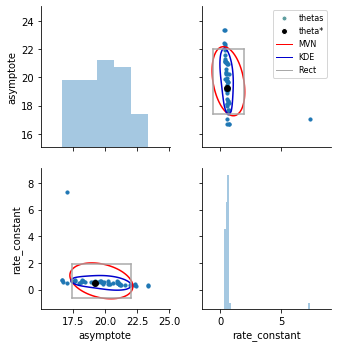

In [11]:
parmest.pairwise_plot(bootstrap_theta, theta, 0.8, ['MVN', 'KDE', 'Rect'])

In [16]:
asym = np.arange(10, 30, 2)
rate = np.arange(0, 1.5, 0.1)
theta_vals = pd.DataFrame(list(product(asym, rate)), columns=theta_names)

obj_at_theta = pest.objective_at_theta(theta_vals)
print(obj_at_theta.head())

   asymptote  rate_constant         obj
0         10            0.0  237.896667
1         10            0.1  154.406436
2         10            0.2  110.231084
3         10            0.3   85.085567
4         10            0.4   69.931834


   asymptote  rate_constant         obj    0.8   0.85    0.9   0.95
0         10            0.0  237.896667  False  False  False  False
1         10            0.1  154.406436  False  False  False  False
2         10            0.2  110.231084  False  False  False  False
3         10            0.3   85.085567  False  False  False  False
4         10            0.4   69.931834  False  False  False  False


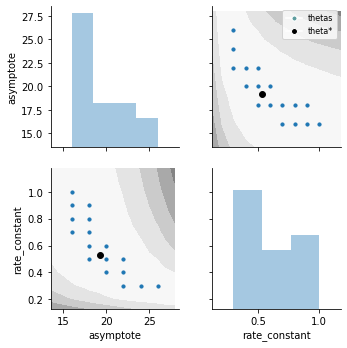

In [17]:
LR = pest.likelihood_ratio_test(obj_at_theta, obj, [0.8, 0.85, 0.9, 0.95])
print(LR.head())

parmest.pairwise_plot(LR, theta, 0.8)